# Learning Experiment

In [1]:
from draco.learn import linear
from draco.learn import data_util
from draco.run import run
from draco.spec import Task, Query, AspTask, Encoding, Field, Data
from draco.learn.helper import count_violations, current_weights
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import logging
from vega3 import VegaLite

logging.basicConfig()
logging.getLogger().setLevel(logging.ERROR)

In [2]:
data, _ = data_util.load_data(test_size=0)
data = data[data.source != 'manual']

raw_data = data_util.load_neg_pos_specs()

data_yh = data[data.source == 'kim2018'] 
data_bh = data[data.source == 'saket2018']

X = data.negative - data.positive
X_yh = data_yh.negative - data_yh.positive
X_bh = data_bh.negative - data_bh.positive

In [3]:
len(data_yh), len(X_yh), len(X_bh), len(data_bh)

(1152, 1152, 10, 10)

In [37]:
X_yh_train, X_yh_test = train_test_split(X_yh, test_size=0.3)
X_bh_train, X_bh_test = train_test_split(X_bh, test_size=0.3)
X_train = pd.concat([X_yh_train, X_bh])
X_test = pd.concat([X_yh_test, X_bh])

In [52]:
clf = linear.train_model(X_train, test_size=0.3)
print()
print(clf.score(X, np.ones(len(X))))
print(clf.score(X_test, np.ones(len(X_test))))
print(clf.score(X_yh_test, np.ones(len(X_yh_test))))
print(clf.score(X_bh, np.ones(len(X_bh))))

Train score:  0.9562171628721541
Dev score:  0.9183673469387755

0.9371772805507745
0.9185393258426966
0.9190751445086706
0.9


In [53]:
clf = linear.train_model(X_bh, test_size=0)

clf.score(X_bh, np.ones(len(X_bh)))

Train score:  1.0


1.0

In [54]:
clf = linear.train_model(X_yh_train, test_size=0.3)

clf.score(X_yh_test, np.ones(len(X_yh_test)))

Train score:  0.9609929078014184
Dev score:  0.9049586776859504


0.9104046242774566

# Apply hand-tuned weights

In [61]:
features = X.columns

w = current_weights()
weights = np.array([w[f'{f}_weight'] for f in features])

clf.coef_ = np.array([weights])

In [62]:
print(clf.score(X_test, np.ones(len(X_test))))

0.651685393258427


# Accuracy with less training data

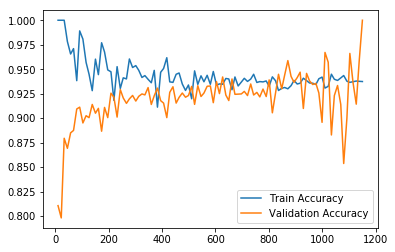

In [8]:
df = pd.DataFrame(columns=['Train Accuracy', 'Validation Accuracy'])

for size in range(1, 100):
    test_size = 1.0 * size/100
    X_train, X_test = train_test_split(X, test_size=test_size)
    
    clf = linear.train_model(X_train, test_size=0, quiet=True)

    df = df.append(pd.DataFrame({
        'Train Accuracy': clf.score(X_train, np.ones(len(X_train))),
        'Validation Accuracy': clf.score(X_test, np.ones(len(X_test))) 
    }, index=[len(X_train)]))

df
    
df.plot()

# Apply a learned model to partial specifications

See whether it comes up with the optimum

In [9]:
clf = linear.train_model(X, test_size=0)

Train score:  0.9371772805507745


In [10]:
weights = clf.coef_[0]
names = X.columns

const_dict = dict(zip(map(lambda x: f'{x}_weight', names), map(int, weights*1000)))

# Kim et al

In [11]:
def to_name(spec):
    enc = spec['encoding']
    
    d = {}
    
    d[enc['x']['field']] = 'x'
    d[enc['y']['field']] = 'y'
    
    if 'color' in enc:
        color = enc['color']['field']
        d[color] = 'color'
    if 'size' in enc:
        size = enc['size']['field']
        d[size] = 'size'
    if 'row' in enc:
        row = enc['row']['field']
        d[row] = 'row'

    return f'Q1:{d["q1"]}, Q2:{d["q2"]}, N:{d["n"]}'

In [12]:
def get_yh_encoding(cardinality, per_category, entropy_q1, entropy_q2, task, weights):
    num_rows = per_category * cardinality
    fields = list(map(Field.from_obj, [
        {
          "name": "n",
          "type": "string",
          "entropy": 1,
          "cardinality": cardinality,
          "interesting": task == 'summary'
        }, {
          "name": "q1",
          "type": "number",
          "entropy": entropy_q1,
          "cardinality": num_rows,
          "interesting": True
        }, {
          "name": "q2",
          "type": "number",
          "entropy": entropy_q2,
          "cardinality": num_rows
        }
    ]))
    spec_schema = Data(fields, num_rows)
    spec_schema.fill_with_random_content()

    query_task = Task(spec_schema,
                Query(
                    mark=None,
                    encodings=[
                        Encoding(field='q1', ty='quantitative'),
                        Encoding(field='q2', ty='quantitative'),
                        Encoding(field='n', ty='nominal')
                    ]),
                task=task)

    return run(query_task,
        constants=weights,
        files=['define.lp', 'generate.lp', 'hard.lp', 'soft.lp',
               'assign_weights.lp', 'optimize.lp', 'output.lp', 'kim2018.lp'],
        clear_cache=True)

In [13]:
cardinalities = [3, 10, 20]
per_categories = [3, 30]
entropy = [3.9, 0.8]
tasks = ['value', 'summary']

In [14]:
# check whether we get the right spec every single time

good = 0.0
overall = 0.0

# created in "Process responses"
%store -r perfects_yh

for task in tasks:
    for cardinality in cardinalities:
        for per_category in per_categories:
            for entropy_q1 in entropy:
                for entropy_q2 in entropy:
                    out = get_yh_encoding(cardinality, per_category, entropy_q1, entropy_q2, task, const_dict)
                    #print(task, ',', cardinality, ',', per_category, ',', entropy_q1, ',', entropy_q2, ',', to_name(out.to_vegalite()))
                    data_key = f'{per_category * cardinality},{"H" if entropy_q1 > 1 else "L"},{"H" if entropy_q2 > 1 else "L"}'
                    optimal = perfects_yh[task][data_key]
                    
                    spec = to_name(out.to_vegalite())
                    
                    only_optimal = spec in optimal
                    if not only_optimal:
                        print('Not optimal:', task, data_key, spec)
                    else:
                        good += 1
                    overall += 1

print('Fraction of correct', good / overall, overall)

Fraction of correct 1.0 48.0


In [15]:
#                      0            1            2            3            4            5
configurations = [(0,0,0,0,0), (1,0,0,0,0), (2,0,0,0,0), (0,1,0,0,0), (0,0,1,0,0), (0,0,0,1,0),
                  (0,0,0,0,1), (1,0,0,0,1), (2,0,0,0,1), (0,1,0,0,1), (0,0,1,0,1), (0,0,0,1,1)]
#                       6           7            8            9           10           11

cardinality = cardinalities[0]  # 0,1,2
per_category = per_categories[1]  # 0,1
entropy_q1 = entropy[0]  # 0,1
entropy_q2 = entropy[1]  # 0,1
task = tasks[1]  # 0,1

# config = configurations[11]

Cost: -1978
Q1:y, Q2:x, N:color


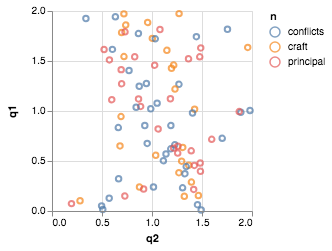

In [64]:
out = get_yh_encoding(cardinality, per_category, entropy_q1, entropy_q2, 'value', const_dict)  # const_dict or current_weights()

print('Cost:', out.cost)
spec = out.to_vegalite()
print(to_name(spec))
VegaLite(spec)

Cost: -204
Q1:y, Q2:color, N:x


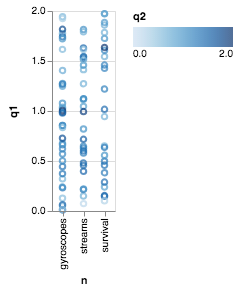

In [17]:
out = get_yh_encoding(cardinality, per_category, entropy_q1, entropy_q2, 'summary', const_dict)  # const_dict or current_weights()

print('Cost:', out.cost)
spec = out.to_vegalite()
print(to_name(spec))
VegaLite(spec)

Cost: 32
Q1:x, Q2:y, N:color


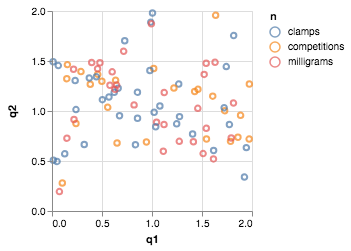

In [18]:
out = get_yh_encoding(cardinality, per_category, entropy_q1, entropy_q2, task, current_weights())  # const_dict or current_weights()

print('Cost:', out.cost)
spec = out.to_vegalite()
print(to_name(spec))
VegaLite(spec)

# Saket et al

Cost: -1257


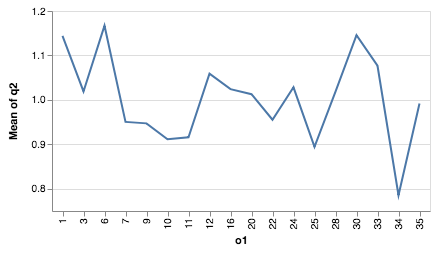

In [19]:
datasets = ['CarData', 'MovieData']

def get_bh_encoding(task, dataset, encoding):
    num_rows = 407 if dataset == 'CarData' else 335

    fields = list(map(Field.from_obj, [
        {
          "name": "n",
          "type": "string",
          "cardinality": 9
        },
        {
          "name": "o1",
          "type": "number",
          "cardinality": 25
        },
        {
          "name": "q2",
          "type": "number",
          "cardinality": 407
        }
    ]))
    spec_schema = Data(fields, num_rows)
    spec_schema.fill_with_random_content()

    encodings = [Encoding(channel='y', field='q2', ty='quantitative', aggregate='mean')]
    
    if encoding == 'Numerical':
        encodings.append(Encoding(channel='x', field='o1', ty='quantitative'))
    elif encoding == 'Ordinal':
        encodings.append(Encoding(channel='x', field='o1', ty='ordinal'))
    elif encoding == 'Nominal':
        encodings.append(Encoding(channel='x', field='n', ty='nominal'))
    else:
        raise ValueError(encoding)
    
    query_task = Task(spec_schema,
                Query(
                    mark=None,
                    encodings=encodings),
                task=task
               )

    return run(query_task,
        constants=const_dict,
        files=['define.lp', 'generate.lp', 'hard.lp', 'soft.lp',
               'assign_weights.lp', 'optimize.lp', 'output.lp', 'saket2018.lp'],
        clear_cache=True
       )
    
out = get_bh_encoding(tasks[0], datasets[0], 'Ordinal')

print('Cost:', out.cost)

spec = out.to_vegalite()
VegaLite(spec)

In [20]:
good = 0.0
overall = 0.0

# created in "Process responses"
%store -r perfects_bh

for task in tasks:
    for x in ['Ordinal', 'Nominal']:  # exclude 'Numerical' as it requires using quantitative as group by
        for dataset in datasets:
            num_rows = 407 if dataset == 'CarData' else 335
                
            data_key = f'{x}_{num_rows}'
            optimal = perfects_bh[task][data_key]
            
            out = get_bh_encoding(task, dataset, x)

            mark = out.to_vegalite()['mark']

            only_optimal = mark in optimal
            if not only_optimal:
                print('Not optimal:', task, data_key, dataset, mark)
            else:
                good += 1
            overall += 1

print('Fraction of correct', good / overall, overall)

Fraction of correct 1.0 8.0
